### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import metrics

In [2]:
leads = pd.read_csv("C:/Users/Sanke/Downloads/ded03f4f-6db1-468b-b4fd-16e5a6763385-Lead-Scoring-Case-Study/Lead Scoring Assignment/Leads.csv")
print(leads.head())

                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0 

In [3]:
print(leads.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [4]:
print(leads.describe())

         Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     

### Data Cleaning and Preprocessing

In [5]:
print(f"Duplicate entries found: {leads.duplicated().sum()}")
leads.drop_duplicates(inplace=True)
leads = leads.replace('Select', np.nan)
missing_percent = round(100 * (leads.isnull().sum() / len(leads)), 2)
print(missing_percent[missing_percent > 0])
for col in leads.columns:
    if leads[col].dtype == 'object':
        leads[col].fillna(leads[col].mode()[0], inplace=True)
    else:
        leads[col].fillna(leads[col].median(), inplace=True)
varlist =  ['Do Not Email', 'Do Not Call', 'Search', 'Newspaper']
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

leads[varlist] = leads[varlist].apply(binary_map)

Duplicate entries found: 0
Lead Source                                       0.39
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Tags                                             36.29
Lead Quality                                     51.59
Lead Profile                                     74.19
City                                             39.71
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Index                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Profile Score                       45.65
dtype: float64


### Exploratory Data Analysis (EDA) & Dummy Variables

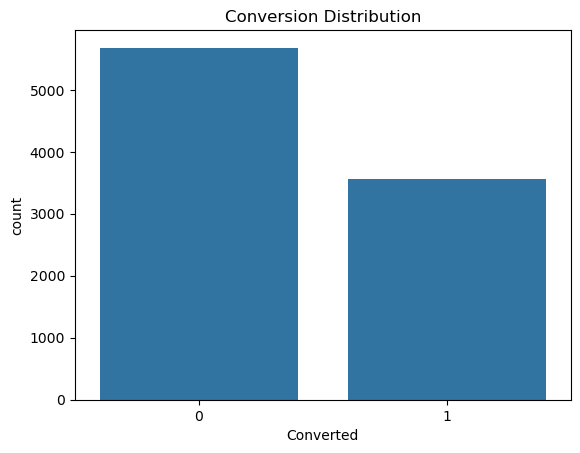

In [6]:
sns.countplot(x='Converted', data=leads)
plt.title('Conversion Distribution')
plt.show()

In [ ]:
cat_cols = leads.select_dtypes(include=['object']).columns
dummy_df = pd.get_dummies(leads[cat_cols], drop_fi                          rst=True)
leads_final = pd.concat([leads, dummy_df], axis=1)
leads_final = leads_final.drop(columns=cat_cols)

print(leads_final.shape)
print(leads_final.dtypes.value_counts()) # Verify 'object' count is 0

# OPTIONAL: Explicitly convert the entire feature set to numeric, coercing errors
# This is a strong defensive step against residual object types.
for c in leads_final.columns:
    if leads_final[c].dtype == 'object':
        try:
            # Try to convert to numeric, making non-convertible items NaN
            leads_final[c] = pd.to_numeric(leads_final[c], errors='coerce')
        except:
            # Drop the column if it absolutely cannot be converted (e.g., text IDs)
            leads_final = leads_final.drop(columns=[c])

# Fill any new NaNs that might have been introduced by coercion (e.g., if a few rows were non-numeric)
leads_final.fillna(0, inplace=True)

(9240, 9421)
bool       9410
int64         7
float64       4
Name: count, dtype: int64


### Train-Test Split and Scaling

In [8]:
X = leads_final.drop(['Converted'], axis=1)
y = leads_final['Converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
logreg = LogisticRegression()
# Use a higher max_iter for RFE's internal LR to ensure convergence
rfe = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)
col = X_train.columns[rfe.support_]
print("RFE Selected Columns (Initial 15):", col.tolist())

# Function to build model using Statsmodels
def build_model(cols):
    X_train_numeric = X_train[cols].astype(float)
    X_train_sm = sm.add_constant(X_train_numeric)

    logm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
    res = logm.fit(method='bfgs', max_iter=100) 
    print(res.summary())
    return res

res = build_model(col)

# Function to check VIF
def check_vif(cols):
    vif = pd.DataFrame()
    vif['Features'] = cols
    X_numeric_vif = X_train[cols].astype(float)
    
    vif['VIF'] = [variance_inflation_factor(X_numeric_vif.values, i) for i in range(X_numeric_vif.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print("\n--- VIF Check ---\n", vif)

check_vif(col)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit on training data
rf.fit(X_train, y_train)

# Predict on test data
y_test_pred_rf = rf.predict_proba(X_test)[:,1]

# Quick Evaluation
print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_test_pred_rf > 0.35))
print("Random Forest AUC:", metrics.roc_auc_score(y_test, y_test_pred_rf))

In [ ]:
X_train_numeric = X_train[col].astype(float) 
X_train_sm = sm.add_constant(X_train_numeric, prepend=False) 
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'Converted': y_train.values, 'Converted_Prob': y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)

cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensi', 'speci'])

for i in numbers:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

# Plot to find the intersection point
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.title('Optimal Cutoff Point')
plt.show()

# Precision-Recall Tradeoff (Useful given the CEO's specific request)
p, r, thresholds = metrics.precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)
plt.plot(thresholds, p[:-1], "g-", label="Precision")
plt.plot(thresholds, r[:-1], "r-", label="Recall")
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
X_test_numeric = X_test[col].astype(float)
X_test_sm = sm.add_constant(X_test_numeric, prepend=False)
y_test_pred = res.predict(X_test_sm)
optimal_cutoff = 0.35
y_test_pred_final = pd.DataFrame({'Converted': y_test.values, 'Converted_Prob': y_test_pred})
y_test_pred_final['final_predicted'] = y_test_pred_final.Converted_Prob.map(lambda x: 1 if x > optimal_cutoff else 0)

# Check Accuracy and Metrics on Test set
print("Accuracy:", metrics.accuracy_score(y_test_pred_final.Converted, y_test_pred_final.final_predicted))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.final_predicted))

In [ ]:
y_test_pred_final['Lead_Score'] = y_test_pred_final.Converted_Prob.map(lambda x: round(x*100))

print(y_test_pred_final.sort_values(by='Lead_Score', ascending=False).head())

In [ ]:
# Create a DataFrame for model coefficients
params = pd.DataFrame(res.params)
params.columns = ['Coefficient']

# Drop the intercept (constant) for interpretation of features
params = params.drop('const')

# Calculate the Odds Ratio (e^coefficient)
params['Odds Ratio'] = np.exp(params['Coefficient'])

# Sort by Odds Ratio to easily identify the strongest predictors
params_sorted = params.sort_values(by='Odds Ratio', ascending=False)

print("\n--- Model Feature Interpretation (Top 10 Predictors) ---\n")
print(params_sorted.head(10))